Kasu honetan IB neurona dugu.

Erabiliko diren moduluak:

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

### IB Neuronarako erabiliko diren konstanteen multzoa

Erabiliko diren aldagaien laburbilduma:

|Aldagaia|Definizioa|Unitatea|
|--------|-----------|-------|
|$t_{max}$ |Simulazioa denbora maximoa|$ms$|
|$\Delta t$|Denboraren diskretizazioa |$ms$|
|$\tau_{max}$ |Parametro esperimentala|$s$|
|$C_{m}$   |Mintz kapazitatea         |$\frac{\mu F}{cm^{2}}$|
|$E_{Na}$  |Inbertsio potentziala, sodio kanaletarako|$mV$|
|$E_{K}$   |Inbertsio potentziala, potasio kanaletarako|$mV$|
|$E_{L}$   |Inbertsi potentziala|$mV$|
|$E_{Ca}$   |Inbertsi potentziala, kaltzio kanaletarako|$mV$|
|$g_{Na}$  |Konduktantzia espezifikoa, sodio korronte azkarrerako|$\frac{mS}{cm^{2}}$|
|$g_{K}$   |Konduktantzia espezifikoa, potasio korronte iraukorrerako|$\frac{mS}{cm^{2}}$|
|$g_{M}$   |Konduktantzia espezifikoa, potasio korronte geldorako|$\frac{mS}{cm^{2}}$|
|$g_{L}$   |Konduktantzia espezifikoa|$\frac{mS}{cm^{2}}$|
|$g_{Ca}$   |Konduktantzia espezifikoa, kaltzio korronte leherketarako|$\frac{mS}{cm^{2}}$|
|$i_{mean}$|Batez-besteko intentsitate bat finkatu|$\frac{\mu A}{cm^{2}}$|
|$V_{rest}$|Egoera egonkorreko mintz potentziala|$mV$|
|$V_{Th}$|Atari potentziala|$mV$|

In [2]:
#Parametroak finkatu#####
t_max=600      # ms
delta_t=0.04   # ms
tau_max=500.0  # s
C_m=3.14       # micro F/cm^2 (c_m/(L*d)=C_m)
E_Na=50.00     # mV
E_K=-90.00     # mV
E_L=-70.00     # mV
E_Ca=120.0     # mV
g_Na=50.0      # mS/cm^2
g_K=5.0        # mS/cm^2
g_M=0.07       # mS/cm^2
g_L=0.1       # mS/cm^2
g_Ca=0.1       # mS/cm^2  
i_mean=3.5000     # microA/cm^2
V_rest=-65.0   # mV
v_th=-40.0     # mV

### Funtzio laguntzaileen inplementazioa

$$\alpha_{m}=\frac{-0.32(v-v_{Th}-13)}{\exp [-(v-v_{Th}-13)/4]-1}$$

$$\beta_{m}=\frac{0.28(v-v_{Th}-40)}{\exp [(v-v_{Th}-40)/5]-1}$$

$$\alpha_{h}=0.128\exp [-(v-v_{Th}-17)/18]$$

$$\beta_{h}=\frac{4}{1+ exp[-(v-v_{Th}-40)/5]}$$

$$\alpha_{n}=\frac{-0.032(v-v_{Th}-15)}{\exp [-(v-v_{Th}-15)/5]-1}$$

$$\beta_{n}=0.5 \exp[-(v-v_{Th}-10)/40]$$

$$p_{\infty}(v)=\frac{1}{1+\exp[-(v+35)/10]}$$

$$\tau_{p}(v)=\frac{\tau_{max}}{3.3\exp[(v+35)/20]+\exp[-(v+35)/20]}$$

$$\alpha_{q}=\frac{0.055(-27-v)}{\exp [(-27-v)/3.9]-1}$$

$$\beta_{q}=0.94 \exp[(-75-v)/17]$$

$$\alpha_{r}=0.000457 \exp[(-13-v)/50]$$

$$\beta_{r}=\frac{0.0065}{1+ exp[(-15-v)/28]}$$

In [3]:
def alpha_m(v):
    return -0.32 * (v - v_th - 13.0) / (np.exp(-(v - v_th - 13.0) / 4.0) - 1.0)

def beta_m(v):
    return 0.28 * (v - v_th - 40.0) / (np.exp((v - v_th - 40.0) / 5.0) - 1.0)

def alpha_h(v):
    return 0.128 * np.exp(-(v - v_th - 17.0)/18.0)

def beta_h(v):
    return 4.0 / (1.0 + np.exp(-(v - v_th - 40.0) / 5.0))

def alpha_n(v):
    return -0.032 * (v - v_th - 15.0) / (np.exp(-(v - v_th - 15.0) / 5.0) - 1.0)

def beta_n(v):
    return 0.5 * np.exp(-(v - v_th - 10.0) / 40.0)

def p_infty(v):
    return 1.0 / (1.0 + np.exp(-(v + 35.0) / 10.0))

def tau_p(v):
    return tau_max / (3.3 * np.exp((v + 35.0) / 20.0) + np.exp(-(v + 35.0) / 20.0))

def alpha_q(v):
    return 0.055 * (-27.0 - v) / (np.exp((-27.0 - v) / 3.8) - 1.0)

def beta_q(v):
    return 0.94 * np.exp((-75.0 - v) / 17.0)

def alpha_r(v):
    return 0.000457 * np.exp((-13.0 - v) / 50.0)

def beta_r(v):
    return 0.0065 / (np.exp((-15.0 - v) / 28.0) + 1.0)

### Bektoreak eta hasierako balioak finkatu

In [4]:
#Denbora eremu osoa finkatzen dugu. 0 s-tik hasiz, delta_t diskretizazio denbora aldiunez t_max aldiunerarte
t_eremua=np.arange(0,t_max,delta_t)
#Luzera finkatu
step=len(t_eremua)

#Vt bektorea finkatu
Vt=np.ones([step])

#Fase espaziorako bektoreaa finkatu
V_dot=np.ones([step])

#nt, mt, ht bektoreak finkatu
nt=np.ones([step])
mt=np.ones([step])
ht=np.ones([step])
pt=np.ones([step])
qt=np.ones([step])
rt=np.ones([step])

#Fase espaziorako bektoreak finkatu
n_dot=np.ones([step])
m_dot=np.ones([step])
h_dot=np.ones([step])
p_dot=np.ones([step])
q_dot=np.ones([step])
r_dot=np.ones([step])

# Atari Intentsitatea

Kode honetan IB neuronaren atari intentsitatea lortuko da. Honekin batera bi irudi adieraziko dira. Atari intentsitateak ematen duena eta hau baino pausu bat atzerago dagoen intentsitateak ematen duen mintz potentziala. Honetaroko intentsitatea gutxienaka handitzen joango da eta aldiuneren batean ekintza potentzial bat gauzatzen bada, atari potentziala lortu dela ondorioztatu ahalko da. Hala ere, lehenengo mintz potentzialari erlaxazio egoera bat lortzen utziko zaio. Hau da, $i_{e}=0.0$-rako $V_{t}$ lortzen joango gara. $V_{t}[i+1]-V_{t}[i]<\epsilon$ bada, mintz potentziala erlaxatu dela esan dezakegu. Hau denbora aldiune batean emango da. Beraz hemendik aurrera atari intentsitatea bilatuko da.

### Gobernu ekuazioen ebazpena
Euler-en aurrerazko formula erabiliz diskretizazioa denboran egiteko:


$$v^{i+1}=v^{i}+\frac{\Delta t}{C_{m}}[I^{i}-\overline{g_{Na}}(m^{3})^{i}h^{i}(v^{i}-E_{Na})-\overline{g_{K}}(n^{4})^{i}(v^{i}-E_{K})-\overline{g_{M}}p^{i}(v^{i}-E_{K})-\overline{g_{Ca}}(q^{2})^{i}r^{i}(v^{i}-E_{Ca})-\overline{g_{L}}(v^{i}-E_{L})]$$

$$n^{i+1}=n^{i}+\Delta t[\alpha_{n}(v^{i})(1-n^{i})-\beta_{n}(v^{i})n^{i}]$$

$$m^{i+1}=m^{i}+\Delta t[\alpha_{m}(v^{i})(1-m^{i})-\beta_{m}(v^{i})m^{i}]$$

$$h^{i+1}=h^{i}+\Delta t[\alpha_{h}(v^{i})(1-h^{i})-\beta_{h}(v^{i})h^{i}]$$

$$p^{i+1}=p^{i}+\Delta t[\frac{p_{\infty}(v^{i})-p^{i}}{\tau_{p}(v^{i})}]$$

$$q^{i+1}=q^{i}+\Delta t[\alpha_{q}(v^{i})(1-q^{i})-\beta_{q}(v^{i})q^{i}]$$

$$r^{i+1}=r^{i}+\Delta t[\alpha_{r}(v^{i})(1-r^{i})-\beta_{r}(v^{i})r^{i}]$$

Lehenik erlaxazio egoera lortuko dugu:

In [5]:
i_erlaxazio=0.0   # Ez da intentsitaterik erabiliko erlaxazio egoera aurkitzeko.
eps=0.00001       # Erabiliko dugun zehaztasuna erlaxazioa bilatzeko.

#Hasierako baldintzak
Vt[0]=V_rest
nt[0]= alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))
mt[0]= alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
ht[0]= alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
pt[0]= p_infty(V_rest)
qt[0]= alpha_q(V_rest) / (alpha_q(V_rest) + beta_q(V_rest))
rt[0]= alpha_r(V_rest) / (alpha_r(V_rest) + beta_r(V_rest))
#####################

for i in range(0, step-1) :
        nt[i + 1] = nt[i] + delta_t * (alpha_n(Vt[i]) * (1.0 - nt[i]) - beta_n(Vt[i]) * nt[i])
        mt[i + 1] = mt[i] + delta_t * (alpha_m(Vt[i]) * (1.0 - mt[i]) - beta_m(Vt[i]) * mt[i])
        ht[i + 1] = ht[i] + delta_t * (alpha_h(Vt[i]) * (1.0 - ht[i]) - beta_h(Vt[i]) * ht[i])
        pt[i + 1] = pt[i] + delta_t * ((p_infty(Vt[i]) - pt[i]) / tau_p(Vt[i]))
        qt[i + 1] = qt[i] + delta_t * (alpha_q(Vt[i]) * (1.0 - qt[i]) - beta_q(Vt[i]) * qt[i])
        rt[i + 1] = rt[i] + delta_t * (alpha_r(Vt[i]) * (1.0 - rt[i]) - beta_r(Vt[i]) * rt[i])
        Vt[i + 1] = Vt[i] + (delta_t/C_m) * (i_erlaxazio-g_Na * mt[i] ** 3 * ht[i] * (Vt[i]-E_Na) - g_K * nt[i] ** 4 * (Vt[i]-E_K)- g_Ca * qt[i]** 2 * rt[i] * (Vt[i] - E_Ca) - g_M * pt[i] * (Vt[i] - E_K) - g_L * (Vt[i]-E_L)) 
        V_erlaxazio= Vt[i + 1] - Vt[i]
        if abs(V_erlaxazio)<=eps:
            print('Erlaxatu da', i * delta_t, 'aldiunean')
            break

Erlaxatu da 152.36 aldiunean


Beraz, badakigu $t=152.36$ ms-an erlaxatu dela. Beraz, puntu honetatik aurrera atari intentsitatea lortuko dugu, honetarako honako intentsitate forma erabiliko dugu:

In [6]:
def Ia(t):
    if t>=152.36:
        return 1.0
    else:
        return 0.0

Atari intentsitatea aurkitu:

In [7]:
i_atari=0.0 #Atari intentsitatea
stop=0      #Ekintza potentziala ematen deneko aldagaia loop-aren break-a emateko
for k in range (0,1000000):
    # Hasierako balioak
    Vt[0]=V_rest
    nt[0]= alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))
    mt[0]= alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
    ht[0]= alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
    pt[0]= p_infty(V_rest)
    qt[0]= alpha_q(V_rest) / (alpha_q(V_rest) + beta_q(V_rest))
    rt[0]= alpha_r(V_rest) / (alpha_r(V_rest) + beta_r(V_rest))
    I= i_mean +0.0001*k
    print('Honako Intentsitatean goaz:', I, '. Espero dena: 3.5XXX')
    for i in range(0, step-1) :
        nt[i + 1] = nt[i] + delta_t * (alpha_n(Vt[i]) * (1.0 - nt[i]) - beta_n(Vt[i]) * nt[i])
        mt[i + 1] = mt[i] + delta_t * (alpha_m(Vt[i]) * (1.0 - mt[i]) - beta_m(Vt[i]) * mt[i])
        ht[i + 1] = ht[i] + delta_t * (alpha_h(Vt[i]) * (1.0 - ht[i]) - beta_h(Vt[i]) * ht[i])
        pt[i + 1] = pt[i] + delta_t * ((p_infty(Vt[i]) - pt[i]) / tau_p(Vt[i]))
        qt[i + 1] = qt[i] + delta_t * (alpha_q(Vt[i]) * (1.0 - qt[i]) - beta_q(Vt[i]) * qt[i])
        rt[i + 1] = rt[i] + delta_t * (alpha_r(Vt[i]) * (1.0 - rt[i]) - beta_r(Vt[i]) * rt[i])
        Vt[i + 1] = Vt[i] + (delta_t/C_m) * (I * Ia(i*delta_t)-g_Na * mt[i] ** 3 * ht[i] * (Vt[i]-E_Na) - g_K * nt[i] ** 4 * (Vt[i]-E_K)- g_Ca * qt[i]** 2 * rt[i] * (Vt[i] - E_Ca) - g_M * pt[i] * (Vt[i] - E_K) - g_L * (Vt[i]-E_L)) 
        if Vt[i + 1]>=0.0: #Ekintza potentziala ematen bada stop=1 lortzen da
            stop=1
            i_atari=I
            print('Atari intentsitatea honako hau da:')
            print(I)
            break
    if stop==1:
        break

Honako Intentsitatean goaz: 3.5 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5001 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5002 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5003 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5004 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5005 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5006 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5007 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5008 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5009 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.501 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5011 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5012 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5013 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5014 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5015 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5016 . Espero dena: 3.5XXX
Honako Intentsitatean goaz: 3.5017 

In [8]:
print('Atari intentsitatea honako hau da:')
print(i_atari)

Atari intentsitatea honako hau da:
3.5098


Hemen lortu den atari intentsitatearekin eta bere aurreko pausuko intentsitatearekin, mintz potentzialaren bi ezbazpenak egingo dira

# Atari Intentsitatearen eta Honen Aurreko Pausuaren Irudiak

In [9]:
Vt_bai=np.ones([step]) #Ekintza potentziala emango deneko mintz potentziala
Vt_ez=np.ones([step])  #Ekintza potentziala emango ez deneko mintz potentziala

for k in range (0,2):
    # Hasierako balioak
    Vt[0]=V_rest
    nt[0]= alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))
    mt[0]= alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
    ht[0]= alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
    pt[0]= p_infty(V_rest)
    qt[0]= alpha_q(V_rest) / (alpha_q(V_rest) + beta_q(V_rest))
    rt[0]= alpha_r(V_rest) / (alpha_r(V_rest) + beta_r(V_rest))
    I= i_atari - 0.0001*k
    for i in range(0, step-1) :
        nt[i + 1] = nt[i] + delta_t * (alpha_n(Vt[i]) * (1.0 - nt[i]) - beta_n(Vt[i]) * nt[i])
        mt[i + 1] = mt[i] + delta_t * (alpha_m(Vt[i]) * (1.0 - mt[i]) - beta_m(Vt[i]) * mt[i])
        ht[i + 1] = ht[i] + delta_t * (alpha_h(Vt[i]) * (1.0 - ht[i]) - beta_h(Vt[i]) * ht[i])
        pt[i + 1] = pt[i] + delta_t * ((p_infty(Vt[i]) - pt[i]) / tau_p(Vt[i]))
        qt[i + 1] = qt[i] + delta_t * (alpha_q(Vt[i]) * (1.0 - qt[i]) - beta_q(Vt[i]) * qt[i])
        rt[i + 1] = rt[i] + delta_t * (alpha_r(Vt[i]) * (1.0 - rt[i]) - beta_r(Vt[i]) * rt[i])
        Vt[i + 1] = Vt[i] + (delta_t/C_m) * (I * Ia(i * delta_t)-g_Na * mt[i] ** 3 * ht[i] * (Vt[i]-E_Na) - g_K * nt[i] ** 4 * (Vt[i]-E_K)- g_Ca * qt[i]** 2 * rt[i] * (Vt[i] - E_Ca) - g_M * pt[i] * (Vt[i] - E_K) - g_L * (Vt[i]-E_L)) 
    if k==0:
        for i in range (0,step): #I=i_atari -> ekintza potentziala bai
            Vt_bai[i]=Vt[i]
            
            
    if k==1:
        for i in range(0,step): # I=i_atari-0.01 -> ekintza potentziala ez
            Vt_ez[i]=Vt[i]   

Ploteatu:

In [10]:
#fig = plt.figure()
#Neuron potential

#plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.top'] = False

#fig, ax2 = plt.subplots(figsize=(11, 8))

#ax2 = plt.subplot(221)
#ax2.plot(t_eremua, Vt_bai, 'r', label='$i_{e}=3.5098$')
#ax2.set_ylabel('$V_{m} (mV)$',fontsize=15)
#ax2.set_xlabel('$t (ms)$',fontsize=15)
#ax2.set_xlim(152.36,t_max)
#ax2.set_ylim(-80,50)
#fig, ax2.set_title('Mintz potentziala',fontsize=20)
#plt.legend()

#ax3 = plt.subplot(222)
#ax3.plot(t_eremua, Vt_ez, 'g', label='$i_{e}=3.5097$')
#ax3.set_ylabel('$V_{m} (mV)$',fontsize=15)
#ax3.set_xlabel('$t (ms)$',fontsize=15)
#ax3.set_xlim(152.36,t_max)
#ax3.set_ylim(-80,50)
#fig, ax3.set_title('Mintz potentziala',fontsize=20)
#plt.legend()
#plt.savefig('IB_Eredua_Atari_Intentsitatea.png')

In [11]:
Vt[0]=V_rest
nt[0]= alpha_n(V_rest) / (alpha_n(V_rest) + beta_n(V_rest))
mt[0]= alpha_m(V_rest) / (alpha_m(V_rest) + beta_m(V_rest))
ht[0]= alpha_h(V_rest) / (alpha_h(V_rest) + beta_h(V_rest))
pt[0]= p_infty(V_rest)
qt[0]= alpha_q(V_rest) / (alpha_q(V_rest) + beta_q(V_rest))
rt[0]= alpha_r(V_rest) / (alpha_r(V_rest) + beta_r(V_rest))
I= i_atari + 0.0003
print(I)
for i in range(0, step-1) :
    nt[i + 1] = nt[i] + delta_t * (alpha_n(Vt[i]) * (1.0 - nt[i]) - beta_n(Vt[i]) * nt[i])
    mt[i + 1] = mt[i] + delta_t * (alpha_m(Vt[i]) * (1.0 - mt[i]) - beta_m(Vt[i]) * mt[i])
    ht[i + 1] = ht[i] + delta_t * (alpha_h(Vt[i]) * (1.0 - ht[i]) - beta_h(Vt[i]) * ht[i])
    pt[i + 1] = pt[i] + delta_t * ((p_infty(Vt[i]) - pt[i]) / tau_p(Vt[i]))
    qt[i + 1] = qt[i] + delta_t * (alpha_q(Vt[i]) * (1.0 - qt[i]) - beta_q(Vt[i]) * qt[i])
    rt[i + 1] = rt[i] + delta_t * (alpha_r(Vt[i]) * (1.0 - rt[i]) - beta_r(Vt[i]) * rt[i])
    Vt[i + 1] = Vt[i] + (delta_t/C_m) * (I * Ia(i * delta_t)-g_Na * mt[i] ** 3 * ht[i] * (Vt[i]-E_Na) - g_K * nt[i] ** 4 * (Vt[i]-E_K)- g_Ca * qt[i]** 2 * rt[i] * (Vt[i] - E_Ca) - g_M * pt[i] * (Vt[i] - E_K) - g_L * (Vt[i]-E_L)) 

3.5101


<Figure size 432x288 with 0 Axes>

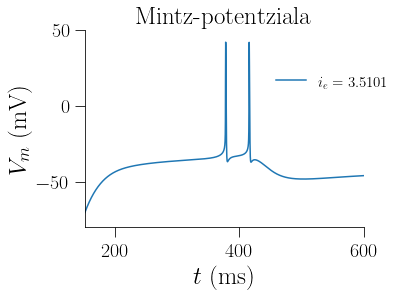

In [12]:
#################################  ### 00 ###

plt.rc('text', usetex=True)

#################################

fig = plt.figure();

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

#################################  ### 01 ###
fontsize = 25
labelsize = 20
#################################

fig, ax2 = plt.subplots(figsize=(11, 8))

ax2 = plt.subplot(221)
ax2.plot(t_eremua, Vt, label=r'$i_{e}=3.5101$')
ax2.set_ylabel(r'$V_{m} \textrm{ (mV)}$',fontsize=fontsize)
ax2.set_xlabel(r'$t \textrm{ (ms)}$',fontsize=fontsize)
ax2.set_xlim(152.36,t_max)
ax2.set_ylim(-80,50)
fig, ax2.set_title(r'$\textrm{Mintz-potentziala}$',fontsize=fontsize)

ax2.legend(bbox_transform=ax2.transData, bbox_to_anchor=(450, 25), ncol=1, borderaxespad=0, 
             frameon=False, fontsize=15)

######################################  ### 04 ###
axes_fig = [ax2] # irudiak dazkanaren arabera

for i in axes_fig:
    i.tick_params(axis='y', labelsize=labelsize, pad=5, length=10);
    i.tick_params(axis='x', labelsize=labelsize, pad=5, length=10)


plt.savefig('IB_Eredua_Atari_Intentsitatea.pdf', format='pdf', dpi=180,bbox_inches="tight")